# Temperature regression

In this exercise, we provide an example of modeling using spatial datasets. The goal is to predict monthly air temperature using satellite based measurements of Land Surface Temeperature (LST) from the MODIS (https://terra.nasa.gov/about/terra-instruments/modis) sensor. The goal is to use the relationship between satellite and ground temperature meteorological stations measurements within a regression model. The ground temperature measurements were obtained from the Global Historical Climate Network. To test the relationship, we predict air temperature for the month of January and July 2010 using MODIS raster layers. The MODIS layers are pre-processed monthly long term averages over the 2001-2012 time period. 

## Documentation and packages

First, we set up the code by providing information on the Authors, Creation dates, version by importing relevant python packages. Documenting and providing context and information within a script is important as it is often the case that code will be reused for other applications or other users/colleagues Good documentation improve code reproducibility as well.

In [50]:
#################################### Regression Temperature #######################################
######################## Analyze and predict air temperature with Earth Observation data #######################################
#This script performs analyses to predict air temperature using several coveriates.
#The goal is to predict air temperature using Remotely Sensing data as well as compare measurements
# from the ground station to the remotely sensed measurements.
#
#AUTHORS: Benoit Parmentier
#DATE CREATED: 09/07/2018
#DATE MODIFIED: 03/26/2019
#Version: 1
#PROJECT: SESYNC Geospatial Course and AAG 2019 Python Geospatial Course
#TO DO:
#
#COMMIT: clean up code for workshop
#
#################################################################################################

###### Library used in this script
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import seaborn as sns
import rasterio
import subprocess
import pandas as pd
import os, glob
from rasterio import plot
import geopandas as gpd
import georasters as gr
import gdal
import rasterio
import descartes
import pysal as ps
from cartopy import crs as ccrs
from pyproj import Proj
from osgeo import osr
from shapely.geometry import Point
from collections import OrderedDict
import webcolors
import sklearn


The packages above are some of the most frequently used for geospatial data processing, wrangling and analysis. Notables packages are geopandas, rasterio, pysal, gdal and shapely. Geopandas extends the pandas package to allow for the use of spatial data using a geometry column in a DataFrame. It implements a version of the Simple Feature model (https://www.opengeospatial.org/standards/sfa) using the "shapely" package to define the geometry of spatial objects. GDAL and Rasterio allows operations and processing on raster layers. Pysal provide spatial analyses tools such as Moran's I and spatial regression modeling. In this exercise, we also use the "sklearn" package that contains some of the most widely known machine learning and regression models (e.g. OLS linear regression, randomForest, svm etc.).  

## Functions

In the next part of the script, we declare all the functions used in the sripts. The first function builds outputs directory while the second function helps in the fitting and testing of the regression model. It is good practice to place functions at the beginning of a script or an external source file.

In [51]:

################ NOW FUNCTIONS  ###################

##------------------
# Functions used in the script
##------------------

def create_dir_and_check_existence(path):
    #Create a new directory
    try:
        os.makedirs(path)
    except:
        print ("directory already exists")

def fit_ols_reg(avg_df,selected_features,selected_target,prop=0.3,random_seed=100):
    #Function to fit a regressio model given a data frame

    X_train, X_test, y_train, y_test = train_test_split(avg_df[selected_features], 
                                                    avg_df[selected_target], 
                                                    test_size=prop, 
                                                    random_state=random_seed)
    
    from sklearn.linear_model import LinearRegression
    regr = LinearRegression().fit(X_train,y_train)

    regr.fit(X_train, y_train)

    y_pred_train = regr.predict(X_train) # Note this is a fit!
    y_pred_test = regr.predict(X_test) # Note this is a fit!

    r2_val_train = regr.score(X_train, y_train) #coefficient of determination (R2)
    r2_val_test = regr.score(X_test, y_test)

    from sklearn import metrics
    #https://scikit-learn.org/stable/modules/classes.html#sklearn-metrics-metrics

    mae_val_test = metrics.mean_absolute_error(y_test, y_pred_test) #MAE
    rmse_val_test = np.sqrt(metrics.mean_squared_error(y_test, y_pred_test)) #RMSE
    mae_val_train = metrics.mean_absolute_error(y_train, y_pred_train) #MAE
    rmse_val_train = np.sqrt(metrics.mean_squared_error(y_train, y_pred_train)) #RMSE
    
    data = np.array([[mae_val_test,rmse_val_test,r2_val_test],
                     [mae_val_train,rmse_val_train,r2_val_train]])
    data_metrics_df = pd.DataFrame(data,columns=['mae','rmse','r2'])
    data_metrics_df['test']=[1,0]
    
    X_test['test'] = 1
    X_train['test'] = 0
    y_test['test'] = 1
    y_train['test'] = 0
    
    X = pd.concat([X_train,X_test],sort=False)
    y = pd.concat([y_train,y_test],sort=False)
    ### return a tuple, could be a dict or list?
    
    residuals_val_test = y_test[selected_target] - y_pred_test
    residuals_val_train = y_train[selected_target] - y_pred_train
    residuals_val_test['test'] = 1   
    residuals_val_train['test'] = 0   
        
    residuals_df = pd.concat([residuals_val_test,residuals_val_train],sort=False)
    
    return X, y, regr, residuals_df,data_metrics_df

## Paremeters and Arguments

It is good practice to set all parameters and input arguments at the beginning of the script. This allows for better control and can make modifications of the scripts for other applications easier. Some arguments relate to path directories, input files and general parameters for use in the analyses (e.g. proportion of hold out).

In [54]:
############################################################################
#####  Parameters and argument set up ###########

#ARGS 1
in_dir="/nfs/bparmentier-data/Data/workshop_spatial/climate_regression/data/"
#in_dir = "/home/bparmentier/c_drive/Users/bparmentier/Data/python/climate_regression/data"
#ARGS 2
out_dir="/nfs/bparmentier-data/Data/workshop_spatial/climate_regression/outputs"
#out_dir = "/home/bparmentier/c_drive/Users/bparmentier/Data/python/climate_regression/outputs"
#ARGS 3
create_out_dir=True #create a new ouput dir if TRUE
#ARGS 4
out_suffix = "exercise4_03252019" #output suffix for the files and ouptut folder
#ARGS 5
NA_value = -9999 # NA flag balue
#ARGS 6
file_format = ".tif"

#ARGS 7
#epsg 2991
crs_reg = "+proj=lcc +lat_1=43 +lat_2=45.5 +lat_0=41.75 +lon_0=-120.5 +x_0=400000 +y_0=0 +ellps=GRS80 +datum=NAD83 +units=m +no_defs"

#ARGS 8
infile_lst_month1 = "lst_mean_month1_rescaled.tif" 
#ARGS 9
infile_lst_month7 = "lst_mean_month7_rescaled.tif" 
#ARGS 10
ghcn_filename = "ghcn_or_tmax_covariates_06262012_OR83M.shp" # climate stations
##ARGS 11
prop = 0.3
#ARGS 12
random_seed= 100

## Input and output directories

Before any analyses, we start the script by creating a new output directory to store new files generated througout the script. Separating inputs from outputs avoids overwriting or modifiying the input source files. It is likely that you will repeath the analyses multiples times and generating a new output directory with a date or version can also help in tracking modeling and analyses outputs with different input arguments. 

In [55]:
################# START SCRIPT ###############################

######### PART 0: Set up the output dir ################

#set up the working directory
#Create output directory

if create_out_dir==True:
    #out_path<-"/data/project/layers/commons/data_workflow/output_data"
    out_dir_new = "output_data_"+out_suffix
    out_dir = os.path.join(out_dir,out_dir_new)
    create_dir_and_check_existence(out_dir)
    os.chdir(out_dir)        #set working directory
else:
    os.chdir(create_out_dir) #use working dir defined earlier

## Reading visualizing data

Part I consists in reading in weather stations data in geopandas DataFrame and loading raster images from MODIS in rasterio objects. We explore the datasets by examining the coordinate systems, size (use "shape") and by displaying a few rows of the new geopanda data frame.

In [56]:
###########################################
### PART I: READ AND VISUALIZE DATA #######

data_gpd = gpd.read_file(os.path.join(in_dir,ghcn_filename)) 
## Extracting information from raster using raster io object
lst1 = rasterio.open(os.path.join(in_dir,infile_lst_month1))
lst7 = rasterio.open(os.path.join(in_dir,infile_lst_month7))
print(type(lst1))
print("Coordinate reference system: ",lst1.crs ) 
      
print(" Rows and columns: ", lst1.shape, "number of rows: ", lst1.height)  

data_gpd.head()  


<class 'rasterio.io.DatasetReader'>
Coordinate reference system:  PROJCS["unnamed",GEOGCS["NAD83",DATUM["North_American_Datum_1983",SPHEROID["GRS 1980",6378137,298.2572221010042,AUTHORITY["EPSG","7019"]],TOWGS84[0,0,0,0,0,0,0],AUTHORITY["EPSG","6269"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433],AUTHORITY["EPSG","4269"]],PROJECTION["Lambert_Conformal_Conic_2SP"],PARAMETER["standard_parallel_1",43],PARAMETER["standard_parallel_2",45.5],PARAMETER["latitude_of_origin",41.75],PARAMETER["central_meridian",-120.5],PARAMETER["false_easting",400000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]]]
 Rows and columns:  (536, 745) number of rows:  536


,station,year,month,day,element,value,mflag,qflag,sflag,lat,...,mmv_05,mmv_06,mmv_07,mmv_08,mmv_09,mmv_10,mmv_11,mmv_12,date,geometry
0,USC00350036,2010,1,1,TMAX,-9999,None,None,None,42.1761,...,90.0,118.0,210.0,198.0,169.0,101.0,48.0,20.0,20100101,POINT (449915.4473939174 47537.72616197648)
1,USC00350036,2010,2,1,TMAX,61,0,None,None,42.1761,...,90.0,118.0,210.0,198.0,169.0,101.0,48.0,20.0,20100201,POINT (449915.4473939174 47537.72616197648)
2,USC00350036,2010,3,1,TMAX,122,0,None,None,42.1761,...,90.0,118.0,210.0,198.0,169.0,101.0,48.0,20.0,20100301,POINT (449915.4473939174 47537.72616197648)
3,USC00350036,2010,4,1,TMAX,44,0,None,None,42.1761,...,90.0,118.0,210.0,198.0,169.0,101.0,48.0,20.0,20100401,POINT (449915.4473939174 47537.72616197648)
4,USC00350036,2010,5,1,TMAX,-9999,None,None,None,42.1761,...,90.0,118.0,210.0,198.0,169.0,101.0,48.0,20.0,20100501,POINT (449915.4473939174 47537.72616197648)


Rasterio provides easy tools to display raster images. We compare the distributio of LST temperatures for the month of July and January.


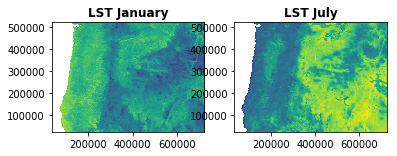

In [165]:
#Generate quick visualization using rasterio object
f, ax = plt.subplots(1, 2)

plot.show(lst1,title="LST January",ax=ax[0])
plot.show(lst7,title="LST July",ax=ax[1])


To manipulate raster data, we read in raster bands directly in numpy arrays and visualize the information. Once, we have arrays, we can perform most of the map algebra or arithmetical operations. We examine differences in temperature between July and January and create a new image (numpy array). From the map display, we can see that larger differences occurs in the eastern part of Oregon. Note that reading raster imagery in arrays may be problematic when we have large images. Alternatives may be to use GDAL tools such gdalcalc to perform map algebra and arithmetical operations as GDAL does not require reading information in memory directly.

Data type for r_lst1 object:  <class 'numpy.ma.core.MaskedArray'>


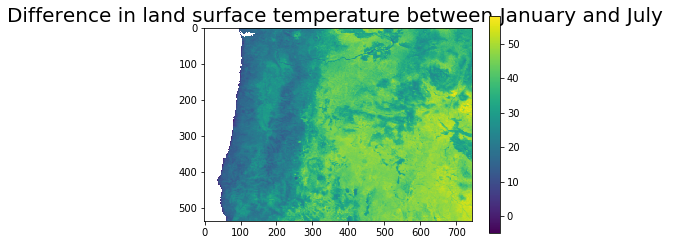

In [166]:
## Read raster bands directly to Numpy arrays and visualize data
r_lst1 = lst1.read(1,masked=True) #read first array with masked value, nan are assigned for NA
r_lst7 = lst7.read(1,masked=True) #read first array with masked value, nan are assigned for NA

spatial_extent = rasterio.plot.plotting_extent(lst1)
print("Data type for r_lst1 object: ",type(r_lst1))
r_lst1.size

r_diff = r_lst7 - r_lst1
plt.imshow(r_diff);
# other way to display data
plt.title("Difference in land surface temperature between January and July ", fontsize= 20)
plt.colorbar()


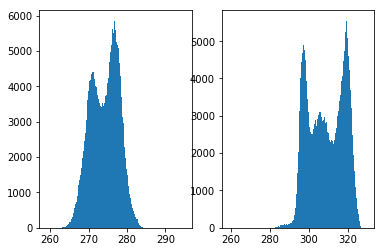

In [177]:
# Explore values distribution
f, ax = plt.subplots(1, 2)
ax[0].hist(r_lst1.ravel(),
         bins=256,
         range=(259.0,295.0));
ax[1].hist(r_lst7.ravel(),
         bins=256,
         range=(259.0,330));

# Combine raster and vector layers on same plot

It is often useful to display both vector and raster layers on the same plot. This can be done using the rasterio package or the standard matplotlib utility. We must first generate a "ax" plot object to add a layer on a existing plot figure.

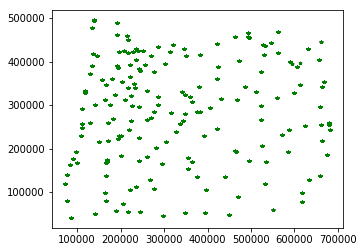

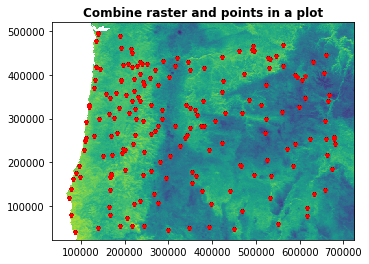

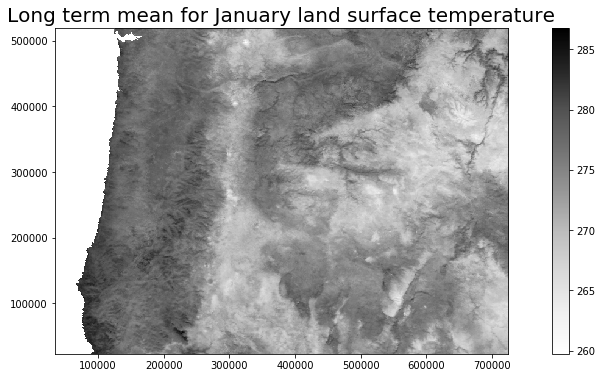

In [63]:
##### Combine raster layer and geogpanda layer

data_gpd.plot(marker="*",color="green",markersize=5)
station_or = data_gpd.to_crs({'init': 'epsg:2991'}) #reproject to  match the  raster image

##### How to combine plots with rasterio package
fig, ax = plt.subplots()
rasterio.plot.show(lst1,ax=ax,
                          clim=(259.0,287.0),
                  title="Combine raster and points in a plot")
station_or.plot(ax=ax,marker="*",
              color="red",
               markersize=10)
               
##### How to combine plots with matplotlib package
fig, ax = plt.subplots(figsize = (16,6))
lst_plot = ax.imshow(r_lst1, 
                       cmap='Greys', 
                       extent=spatial_extent)
ax.set_title("Long term mean for January land surface temperature", fontsize= 20)
fig.colorbar(lst_plot)


## PART II: Extract information from raster and prepare covariates

We use the georaster package to extract values of Land Surface temperature for the month of January and July. The extraction is based on the x and y coordinates of points from the geopandas DataFrame.

,LST1,LST7
0,280.020691,318.788666
1,280.020691,318.788666
2,280.020691,318.788666
3,280.020691,318.788666
4,280.020691,318.788666


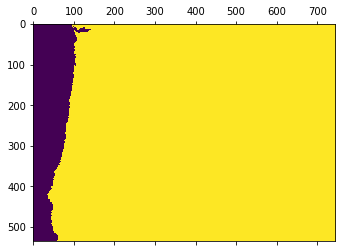

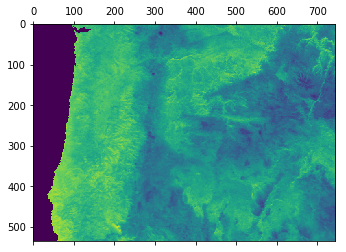

In [64]:
###########################################
### PART II : Extract information from raster and prepare covariates #######

lst1_gr = gr.from_file(os.path.join(in_dir,infile_lst_month1))
lst7_gr = gr.from_file(os.path.join(in_dir,infile_lst_month7))

type(lst1_gr) # check that we have a georaster object
# Plot data
lst1_gr.plot()
lst1_gr.plot(clim=(259.0, 287.0))

#### Extract information from raster using coordinates
x_coord = station_or.geometry.x # pands.core.series.Series
y_coord = station_or.geometry.y
# Find value at point (x,y) or at vectors (X,Y)
station_or['LST1'] = lst1_gr.map_pixel(x_coord,y_coord)
station_or['LST7'] = lst7_gr.map_pixel(x_coord,y_coord)

station_or[['LST1','LST7']].head()

The values extracted are in Kelvins are repeated in each row. We rescale values in degree C and compute averages at each weather station using the "groupby"operator. The goal is to generate monthly LST values for each station.

In [66]:
station_or.columns #get names of col

station_or['year'].value_counts()
station_or.groupby(['month'])['value'].mean() # average by stations per month
     
print("number of rows:",station_or.station.count(),", number of stations:",len(station_or.station.unique()))
station_or['LST1'] = station_or['LST1'] - 273.15 #create new column
station_or['LST7'] = station_or['LST7'] - 273.15 #create new column

station_or_jan = station_or.loc[(station_or['month']==1) & (station_or['value']!=-9999)]
station_or_jul = station_or.loc[(station_or['month']==7) & (station_or['value']!=-9999)]

station_or_jan.head()
station_or_jan.columns
station_or_jan.shape

#avg_df = station_or.groupby(['station'])['value'].mean())
avg_jan_df = station_or_jan.groupby(['station'])['value','LST1','LST7'].mean()
avg_jul_df = station_or_jul.groupby(['station'])['value','LST1','LST7'].mean()

avg_jan_df.head()
avg_jan_df.shape
avg_jul_df.shape
avg_jan_df.head()
avg_jul_df.head()

avg_jan_df['T1'] = avg_jan_df['value']/10
avg_jul_df['T7'] = avg_jul_df['value']/10

avg_jan_df[['LST1','T1']].head()

number of rows: 67053 , number of stations: 186


,LST1,T1
station,,
USC00350036,-266.279297,6.640741
USC00350118,-269.394806,7.542857
USC00350145,-268.399261,10.064286
USC00350197,-270.465393,7.183333
USC00350265,-269.484650,7.061290


##  PART III : Fit model and generate prediction

We first fit a model and split the station into training and testing sets. We will use the proportion of hold out defined in argument (ARGS 8: prop=0.3) and the sklearn functionalities. To make results reproducible, we set the random seed to specific value (see ARGS 9).


In [67]:
################################################
###  PART III : Fit model and generate prediction

#selected_covariates_names_updated = selected_continuous_var_names + names_cat 
selected_features = ['LST1'] #selected features
selected_target = ['T1'] #selected dependent variables
## Split training and testing

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(avg_jan_df[selected_features], 
                                                    avg_jan_df[selected_target], 
                                                    test_size=prop, 
                                                    random_state=random_seed)
   
X_train.shape
y_train.shape


(125, 1)

In [75]:
from sklearn.linear_model import LinearRegression
regr = LinearRegression() #create/instantiate object used for linear regresssion
regr.fit(X_train,y_train) #fit model

y_pred_train = regr.predict(X_train) # Note this is a fit!
y_pred_test = regr.predict(X_test) # Note this is a fit!


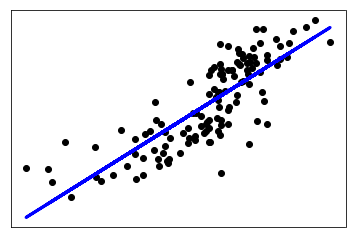

reg coef [[0.6977204]]
reg intercept [196.49846]


In [83]:
#### Model evaluation
from sklearn import metrics
#https://scikit-learn.org/stable/modules/classes.html#sklearn-metrics-metrics
r2_val_test = regr.score(X_test, y_test)
mae_val_test = metrics.mean_absolute_error(y_test, y_pred_test) #MAE
rmse_val_test = np.sqrt(metrics.mean_squared_error(y_test, y_pred_test)) #RMSE

r2_val_train = regr.score(X_train, y_train) #coefficient of determination (R2)
rmse_val_train = np.sqrt(metrics.mean_squared_error(y_train, y_pred_train)) #RMSE
mae_val_train = metrics.mean_absolute_error(y_test, y_pred_test)

data = np.array([[mae_val_test,rmse_val_test,r2_val_test],[mae_val_train,rmse_val_train,r2_val_train]])
    
data_metrics_df = pd.DataFrame(data,columns=['mae','rmse','r2'])
data_metrics_df['test']=[1,0]
#metrics.r2_scores(y_test, y_pred_test)

plt.scatter(X_train, y_train,  color='black')
plt.plot(X_train, regr.predict(X_train), color='blue', linewidth=3)
plt.xticks(())
plt.yticks(())
plt.show()

print('reg coef',regr.coef_)
print('reg intercept',regr.intercept_)


## Use function fit and assess model

We now use the function defined at the beginning of the script to fit and assess the model for the month of January and July. 

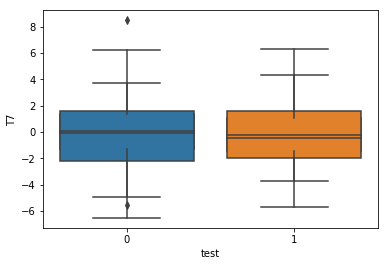

In [151]:
selected_features = ['LST1'] #selected features
selected_target = ['T1'] #selected dependent variables

fit_ols_jan = fit_ols_reg(avg_df=avg_jan_df,
            selected_features = selected_features,
            selected_target = selected_target,
            prop=0.3,
            random_seed=10)

selected_features = ['LST7'] #selected features
selected_target = ['T7'] #selected dependent variables

fit_ols_jul = fit_ols_reg(avg_df=avg_jul_df,
            selected_features = selected_features,
            selected_target = selected_target,
            prop=0.3,
            random_seed=10)

data_metrics = pd.concat([fit_ols_jan[4],fit_ols_jul[4]])
data_metrics['month'] = [1,1,7,7] 
data_metrics

#data_metrics.to_csv
#### now plot residuals

#need to add residuals to outputs!!
#return X_train, X_test, y_train, y_test, regr, data_metrics_df
#y_pred_train = regr.predict(X_train) # Note this is a fit!
#y_pred_test = regr.predict(X_test) # Note this is a fit!

#residuals_val_test = y_test[selected_target] - y_pred_test
#residuals_val_train = y_train[selected_target] - y_pred_train
#residuals_val_test['test'] = 1   
#residuals_val_train['test'] = 0   
        
#residuals_df = pd.concat([residuals_val_test,residuals_val_train],sort=False)
residuals_jan_df =fit_ols_jan[3]
residuals_jul_df =fit_ols_jul[3]

residuals_df.columns
residuals_jan_df['test'] = residuals_jan_df['test'].astype('category')
outfile = os.path.join(out_dir,"residuals_jan_df_"+out_suffix+".csv")
residuals_jan_df.to_csv(outfile)

residuals_jul_df['test'] = residuals_jul_df['test'].astype('category')
outfile = os.path.join(out_dir,"residuals_jul_df_"+out_suffix+".csv")
residuals_jul_df.to_csv(outfile)


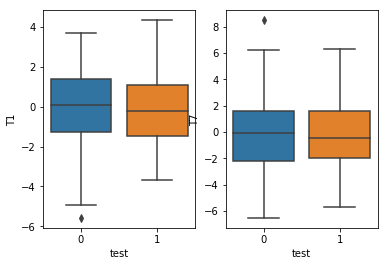

In [160]:
#change data type to categorical

f, axes = plt.subplots(1, 2)
sns.boxplot(ax=axes[0],x='test',y='T1',data=residuals_jan_df)#title='January residuals')
sns.boxplot(ax=axes[1],x='test',y='T7',data=residuals_jul_df) #title='July residuals')

###################### END OF SCRIPT ################################
